In [41]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import pandas as pd
import json
import os
import py_vncorenlp
from underthesea import sent_tokenize
import numpy as np
from rank_bm25 import BM25Okapi
from numpy.random import normal
from scipy.stats import truncnorm, boxcox, gamma
import matplotlib.pyplot as plt

import os, sys
sys.path.append("../src")

from sentences_selection import select_sentences

In [2]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=os.path.abspath('../vncorenlp'))

2023-10-22 20:36:21 INFO  WordSegmenter:24 - Loading Word Segmentation model


In [3]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [4]:
import re
def no_accent_vietnamese(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

def sentences_splitting(text, rdrsegmenter=rdrsegmenter):

    text_lower = no_accent_vietnamese(text.lower())
    
    original_sents=[]
    processed_sents = []
    
    text_pos = 0
    for _, sent in rdrsegmenter.annotate_text(text).items():
        words = [w["wordForm"] for w in sent]
        words = [w.replace("_", " ") if w != "_" else "_" for w in words]

        processed_sents.append(" ".join(words))

        words = [no_accent_vietnamese(w.lower()) for w in words]
        words = sum([w.split() for w in words],[])


        # find position of words in text_lower
        pos_start = []
        pos_end = []

        for w in words:
            idx = text_lower.find(w,text_pos)

            pos_start.append(idx)
            pos_end.append(idx + len(w))

            text_pos = idx + len(w)
        
        # for testing
        # test = [text_lower[pos_start[i]: pos_end[i]] for i in range(len(pos_start))]
        # assert test == words

        original_sents.append(text[pos_start[0]: pos_end[-1]])
    return original_sents, processed_sents


In [5]:
data = pd.read_json("../datasets/ise-dsc01-public-test-offcial.json", orient="index")

In [6]:
idx = 29706

In [7]:
idx = 29706
text = data.loc[idx]["context"]
claim = data.loc[idx]["claim"]
context = rdrsegmenter.word_segment(text)

In [8]:
def clean_str(s):
    return ''.join(e.lower() if e.isalnum() else " " for e in s)

In [30]:
query = no_accent_vietnamese(clean_str(claim)).split()
query

['nen',
 'kiem',
 'tra',
 'gene',
 'tre',
 'so',
 'sinh',
 'khi',
 'gia',
 'dinh',
 'co',
 'nguoi',
 'ung',
 'thu',
 'de',
 'len',
 'ke',
 'hoach',
 'phong',
 'ngua',
 'dieu',
 'tri',
 'som']

In [31]:
[no_accent_vietnamese(clean_str(doc)) for doc in context]

['ngay 13 3   pgs ts pham cam phuong   giam doc trung tam y hoc hat nhan va ung buou   benh vien bach mai   cho biet nhu tren sau khi tiep nhan mot benh nhan nu mac ung thu vu va ung thu buong trung  ',
 'nguoi nay nam 39 tuoi phat hien ung thu vu the ong xam nhap   da phau thuat   hoa tri on dinh  ',
 'bon nam sau   chi tai kham va phat hien ung thu buong trung the thanh dich do cao  ',
 'ca hai the ung thu nay deu lien quan den di truyen do mang dot bien gene  ',
 'me va di ruot cua benh nhan   vao nam 50 tuoi cung phat hien ung thu buong trung   da phau thuat va hoa tri  ',
 'do do   benh nhan duoc chan doan mac hoi chung ung thu vu   buong trung di truyen   ket qua xet nghiem phat hien dot bien gene brca   la nguyen nhan gay ung thu  ',
 'theo tien si phuong   5 15  truong hop ung thu tai viet nam lien quan den di truyen   pho bien la ung thu vu   buong trung   dai truc trang   noi mac tu cung   ung thu tuyen giap the tuy   ung thu tuy   tien liet tuyen  ',
 'gia dinh co nguoi mac 

In [34]:
bm25 = BM25Okapi([no_accent_vietnamese(clean_str(doc)).split() for doc in context])

In [35]:
query_score = bm25.get_scores(query=query)
query_score

array([ 3.04519764,  5.3049452 ,  1.21596995,  2.47142009,  2.85831564,
        2.34387915,  1.63817597,  9.05385777,  5.50939124,  3.40180506,
        6.01978008,  5.27910083, 14.45181801,  2.45656567,  3.46120151,
        6.06252534,  1.9217468 ,  4.06783816,  0.        ])

In [36]:
def distribute_score(score, arr_len, pos):
    myclip_a = 0
    myclip_b = 1
    my_mean = pos/arr_len
    my_std = 0.7 / arr_len
    
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std

    x_range = np.linspace(0,1,arr_len)

    y = truncnorm.pdf(x_range, a, b, loc = my_mean, scale = my_std)

    return score*y/sum(y)
    

In [37]:
# final_doc_scores = np.zeros(len(query_score))

final_doc_scores = sum([distribute_score(score,len(query_score), idx) for idx, score in enumerate(query_score)])
sorted_ids = sorted(range(len(context)), key=lambda k: final_doc_scores[k], reverse=True)

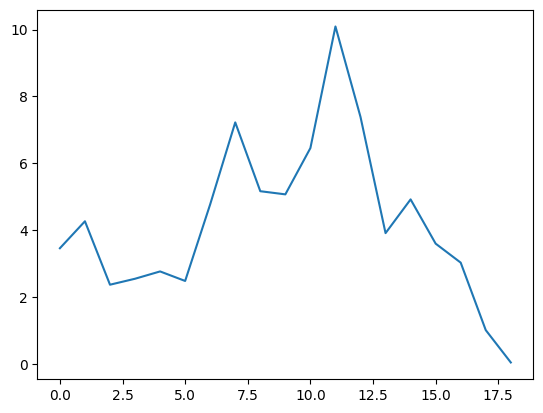

In [38]:
x = range(len(context))

plt.plot(x, final_doc_scores)

In [39]:
claim

'Nên kiểm tra gene trẻ sơ sinh khi gia đình có người ung thư để lên kế hoạch phòng ngừa, điều trị sớm.'

In [40]:
[context[i] for i in sorted_ids]

['Tuỳ trường_hợp , bác_sĩ sẽ chỉ_định xét_nghiệm gene , tầm soát sớm nếu nguy_cơ cao .',
 'Như bệnh_nhân trên , bác_sĩ đã tư_vấn về di_truyền cho cả gia_đình , lên kế_hoạch điều_trị cũng như tầm soát sớm tất_cả thành_viên .',
 'Gia_đình có người mắc các loại ung_thư này cần được tư_vấn về di_truyền để đánh_giá nguy_cơ .',
 'Trường_hợp người_nhà chưa mắc ung_thư , bác_sĩ sẽ phân_tích phả_hệ , khả_năng di_truyền , nguy_cơ bệnh , từ đó đưa ra lời khuyên , kế_hoạch tầm soát , sàng_lọc phù_hợp từng cá_nhân .',
 'Với người đã được chẩn_đoán ung_thư , bác_sĩ phân_tích các đặc_điểm bệnh tỷ_lệ cao liên_quan đến di_truyền do mang các đột_biến gene , như ung_thư vú khi còn trẻ tuổi , nhiều khối_u ở cả hai bên vú , ung_thư vú với thể bộ ba gene âm_tính gồm ER ( - ) , PR ( - ) , Heu-2 / neu ( - ) , ung_thư buồng_trứng_thể biểu mô thanh dịch độ cao .',
 'Sau đó , bác_sĩ đánh_giá nguy_cơ xuất_hiện cùng lúc các loại ung_thư khác .',
 'Đặc_điểm của hội_chứng này là nhiều loại ung_thư xuất_hiện ở nhiều 

In [18]:
claim_tk_length = len(tokenizer(claim).input_ids[:-1])
abstract_len = tokenizer.model_max_length - claim_tk_length - 1
context_tk_length = [len(tokenizer(s).input_ids[:-1]) for s in context]

In [19]:
abstract_len

485

In [20]:
fin_len = 0
mask = [0 for _ in range(len(sorted_ids))]
for i in sorted_ids:
    if fin_len + context_tk_length[i] > abstract_len:
        break
    
    fin_len += context_tk_length[i]
    mask[i] = 1

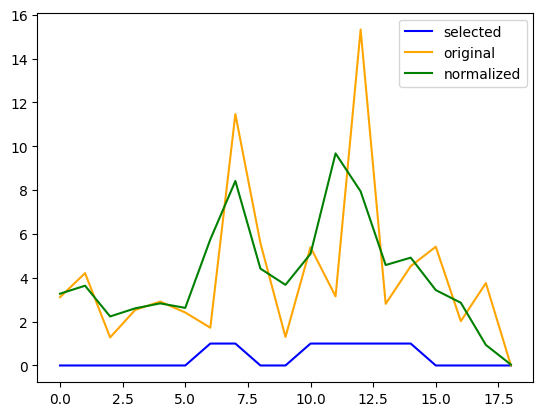

In [21]:
plt.plot(x, mask,color="blue", label="selected")
# original
plt.plot(x, query_score,color="orange",label="original")
# normalized
plt.plot(x, final_doc_scores,color="green", label="normalized")
plt.legend(loc='best')
plt.show()

In [22]:
[context[i] for i in range(len(context)) if mask[i] == 1]

['Theo tiến_sĩ Phương , 5-15% trường_hợp ung_thư tại Việt_Nam liên_quan đến di_truyền , phổ_biến là ung_thư vú , buồng_trứng , đại trực_tràng , nội mạc tử_cung , ung_thư tuyến_giáp_thể tuỷ , ung_thư tuỵ , tiền_liệt_tuyến .',
 'Gia_đình có người mắc các loại ung_thư này cần được tư_vấn về di_truyền để đánh_giá nguy_cơ .',
 'Trường_hợp người_nhà chưa mắc ung_thư , bác_sĩ sẽ phân_tích phả_hệ , khả_năng di_truyền , nguy_cơ bệnh , từ đó đưa ra lời khuyên , kế_hoạch tầm soát , sàng_lọc phù_hợp từng cá_nhân .',
 'Tuỳ trường_hợp , bác_sĩ sẽ chỉ_định xét_nghiệm gene , tầm soát sớm nếu nguy_cơ cao .',
 'Như bệnh_nhân trên , bác_sĩ đã tư_vấn về di_truyền cho cả gia_đình , lên kế_hoạch điều_trị cũng như tầm soát sớm tất_cả thành_viên .',
 'Ung_thư di_truyền được báo_cáo lần đầu_tiên vào năm 1969 bởi hai tiến_sĩ Frederick_Li và Joseph_Fraumeni từ Viện Ung_thư Quốc_gia Mỹ .',
 'Đặc_điểm của hội_chứng này là nhiều loại ung_thư xuất_hiện ở nhiều thế_hệ cùng một gia_đình .']

In [23]:
claim

'Nên kiểm tra gene trẻ sơ sinh khi gia đình có người ung thư để lên kế hoạch phòng ngừa, điều trị sớm.'